# 3D Wind Retrievals

In [6]:
%env ARTS_INCLUDE_PATH=/home/simon/src/arts_clean/controlfiles/
%env ARTS_DATA_PATH=/home/simon/src/arts_xml/
%env ARTS_BUILD_PATH=/home/simon/build/arts_production/arts

%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

from typhon.arts.workspace import Workspace

env: ARTS_INCLUDE_PATH=/home/simon/src/arts_clean/controlfiles/
env: ARTS_DATA_PATH=/home/simon/src/arts_xml/
env: ARTS_BUILD_PATH=/home/simon/build/arts_production/arts


This notebook is essentially a transcript of the `qpack_wind3d_demo.m` script which uses a
three-dimensional atmosphere to retrieve wind speeds.

In [7]:
ws = Workspace()

ws.execute_controlfile("general/general.arts")
ws.execute_controlfile("general/agendas.arts")
ws.execute_controlfile("general/continua.arts")
ws.execute_controlfile("general/planet_earth.arts")

ws.Copy(ws.ppath_agenda,      ws.ppath_agenda__FollowSensorLosPath)
ws.Copy(ws.ppath_step_agenda, ws.ppath_step_agenda__GeometricPath)
ws.Copy(ws.iy_space_agenda,   ws.iy_space_agenda__CosmicBackground)
ws.Copy(ws.iy_surface_agenda, ws.iy_surface_agenda__UseSurfaceRtprop)
ws.Copy(ws.iy_main_agenda,    ws.iy_main_agenda__Emission)

## General Settings

For the wind retrievals, the forward model calculations are performed on a 3D atmosphere grid.
Radiation is assumed to be unpolarized.

In [8]:
ws.atmosphere_dim = 3
ws.stokes_dim     = 1
ws.iy_unit = "RJBT"

## Absorption

We only consider absorption from ozone in this example. The lineshape data is available from
the ARTS testdata available in `controlfiles/testdata`.

In [9]:
ws.abs_speciesSet(["O3"])
ws.abs_lineshapeDefine("Voigt_Kuntz6", "VVH", 750e9)
ws.ReadXML(ws.abs_lines, "testdata/ozone_line.xml")
ws.abs_lines_per_speciesCreateFromLines()

## Atmosphere (A Priori)

In [12]:
z_toa  = 95e3;
z_surf = 1e3;
ws.PFromZSimple(ws.p_grid, np.arange(z_surf - 1e3, z_toa, 2e3))

## Frequency Grid and Sensor

The frequency grid for the simulation consists of 119 grid
points between 110.516 and 111.156 GHz. The frequencies
are given by a degree-10 polynomial that has been obtained from a fit to the data from the original `qpack` example. This is obscure but also kind of cool.

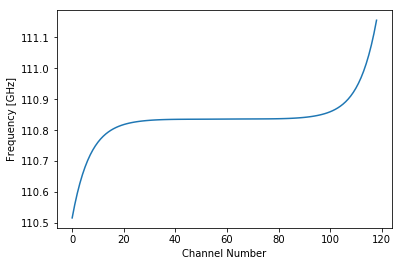

In [17]:
coeffs = np.array([5.06312189e-08, -2.68851772e-05, 6.20655463e-03,
                   -8.16344090e-01,   6.75337174e+01,  -3.66786505e+03,
                   1.32578167e+05,  -3.14514304e+06,   4.57491354e+07,
                   1.10516484e+11])
ws.f_grid = np.poly1d(coeffs)(np.arange(119))

plt.plot(ws.f_grid.value() * 1e-9)
plt.xlabel("Channel Number")
plt.ylabel("Frequency [GHz]")



For the sensor we assume a channel width and channel spacing of 0.05 kHz.

In [14]:
df = 0.05e6
f_backend = np.arange(f_grid.min() + df, f_grid.max() -df, df)